Text(0, 0.5, 'nominal rate, in %')

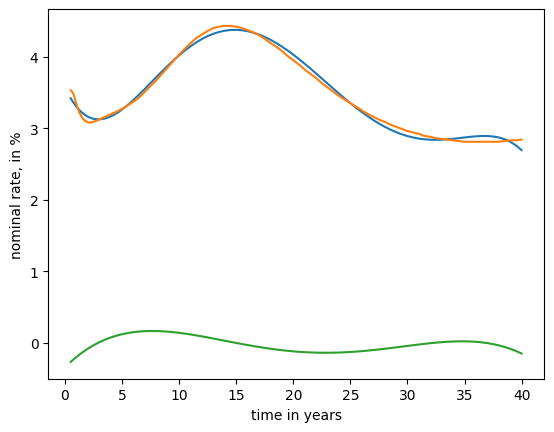

In [2]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("jan_curve.csv", delimiter=",", dtype=float)
# the jan_curve file comes from GLC Nominal month end data_2016 to present, the jan 2023 curve, which is data from the Bank of England

x = data[:,0]
y = data[:,1]

spl = interpolate.UnivariateSpline(x,y,k=5)
plt.plot(x,spl(x))
plt.plot(x,y)
plt.plot(x,spl.derivative()(x))
plt.xlabel("time in years")
plt.ylabel("nominal rate, in %")

40
[-0.09592369 -0.06244385 -0.03235271 -0.00548885  0.01830917  0.03920281
  0.0573535   0.07292267  0.08607178  0.09696226  0.10575556  0.11261311
  0.11769636  0.12116674  0.1231857   0.12391468  0.12351512  0.12214847
  0.11997615  0.11715962  0.11386031  0.11023967  0.10645913  0.10268015
  0.09906415  0.09577258  0.09296688  0.09080849  0.08945885  0.08907941
  0.08983161  0.09187688  0.09537666  0.10049241  0.10738555  0.11621753
  0.1271498   0.14034378  0.15596093  0.17416268]


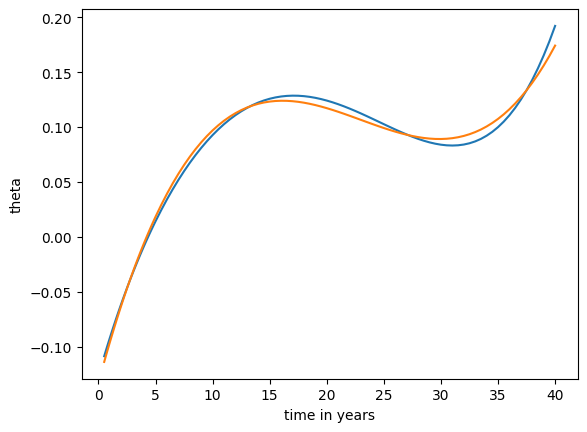

In [3]:
a = 0.1
sigma = 0.1

F = -spl.derivative()(x)
theta = -spl.derivative(n=2)(x) + a * F + sigma**2/a * (1-np.exp(-2 * a * x))

theta_spl = interpolate.UnivariateSpline(x, theta)
plt.plot(x,theta)
plt.plot(x,theta_spl(x))
plt.xlabel("time in years")
plt.ylabel("theta")

final_thetas = theta_spl(range(1,int(x[-1] + 1)))
print(len(final_thetas))
print( final_thetas)

               Month       CPI     Short    Medium      Long  Ultra-Long
Month       1.000000 -0.152776 -0.885336 -0.904331 -0.880437   -0.875096
CPI        -0.152776  1.000000 -0.102965 -0.065602 -0.028241    0.192167
Short      -0.885336 -0.102965  1.000000  0.973662  0.873998    0.789675
Medium     -0.904331 -0.065602  0.973662  1.000000  0.957225    0.925299
Long       -0.880437 -0.028241  0.873998  0.957225  1.000000    0.996954
Ultra-Long -0.875096  0.192167  0.789675  0.925299  0.996954    1.000000


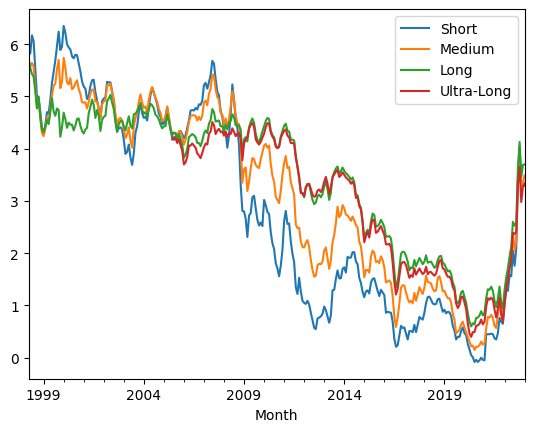

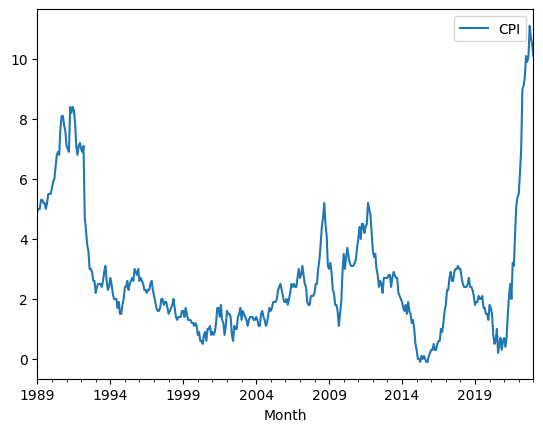

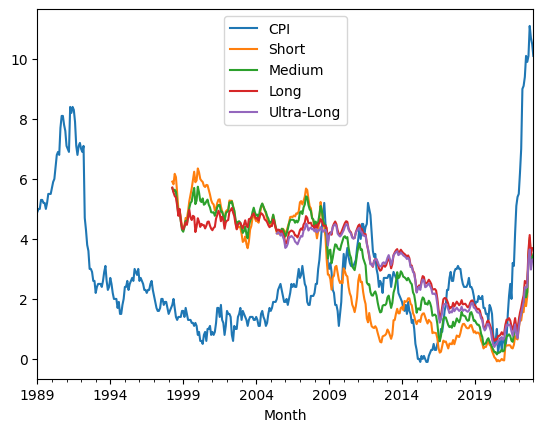

In [12]:
import pandas as pd
def strip_spaces(df):
    return df.replace(r"^ +| +$", r"", regex=True).rename(columns=lambda x: x.strip())

cpi_df = pd.read_csv('../../Data/cpi/cpi_all_1989-2022.csv')
cpi_df = strip_spaces(cpi_df)

gilt_df = pd.read_csv('../../Data/Historical_Average_Daily_Conventional_Gilt_Yields.csv')
gilt_df = strip_spaces(gilt_df)
## load both data sets and find a way to make the timesteps the same 
## then find the pmcc of them both and use that in my model
cpi_df['Month'] = pd.to_datetime(cpi_df['Month'], format="%Y %b")

gilt_df['Month'] = pd.to_datetime(gilt_df['Month'], format="%b-%Y")
#cpi_df = cpi_df[~(cpi_df['Month'] < gilt_df.iloc[0]['Month'])]
#cpi_df = cpi_df[~(cpi_df['Month'] < '01/01/2008')]

gilt_df['Long'] = gilt_df['Long'].str.rstrip('%').astype('float')
gilt_df['Short'] = gilt_df['Short'].str.rstrip('%').astype('float')
gilt_df['Medium'] = gilt_df['Medium'].str.rstrip('%').astype('float')
gilt_df['Ultra-Long'] = gilt_df['Ultra-Long'].str.rstrip('%').astype('float')
#gilt_df = gilt_df[~(gilt_df['Month'] < '01/01/2008')]

gilt_df.plot.line(x="Month")
# gilt_df.plot.line("Month","Short")
# gilt_df.plot("Month","Medium")
# gilt_df.plot("Month","Ultra-Long")
cpi_df.plot("Month","CPI")
df = pd.merge(cpi_df, gilt_df, how="outer", on="Month")
df.plot.line(x="Month")
print(df.corr(method="pearson"))

P-value:  0.03240206989863536
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                  309
Model:                     AutoReg(1)   Log Likelihood                 -83.297
Method:               Conditional MLE   S.D. of innovations              0.317
Date:                Tue, 25 Apr 2023   AIC                            172.593
Time:                        16:15:12   BIC                            183.784
Sample:                             1   HQIC                           177.068
                                  309                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.034      1.085      0.278      -0.030       0.103
CPI.L1         0.9825      0.010     95.529      0.000       0.962       1.003
                      

/home/sophie/miniconda3/envs/projectpython/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


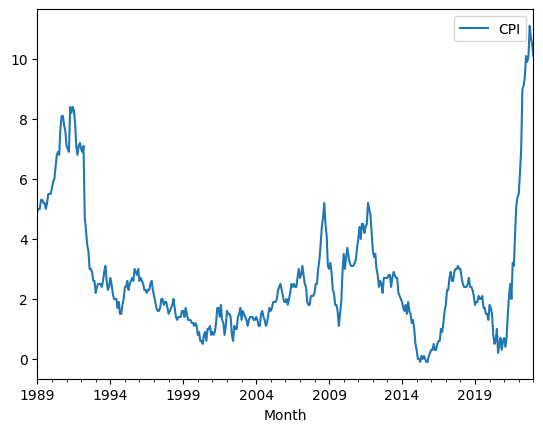

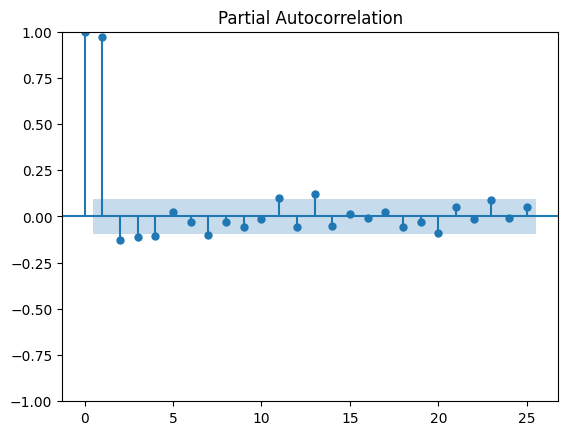

In [24]:
cpi_df = pd.read_csv('../../Data/cpi/cpi_all_1989-2022.csv')
cpi_df = strip_spaces(cpi_df)

cpi_df['Month'] = pd.to_datetime(cpi_df['Month'], format="%Y %b")
cpi_df.plot("Month","CPI")
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
df_stationarityTest = adfuller(cpi_df['CPI'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(cpi_df['CPI'], lags=25)

#
# Create training and test data
#
train_data = cpi_df['CPI'][:len(df)-100]
test_data = cpi_df['CPI'][len(df)-100:]
#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(train_data, lags=1).fit()
#
# Print Summary
#
print(ar_model.summary(0.05))


P-value:  0.4078714157450344
                            AutoReg Model Results                             
Dep. Variable:                   Long   No. Observations:                  298
Model:                     AutoReg(1)   Log Likelihood                 113.205
Method:               Conditional MLE   S.D. of innovations              0.165
Date:                Tue, 25 Apr 2023   AIC                           -220.410
Time:                        17:06:03   BIC                           -209.328
Sample:                             1   HQIC                          -215.973
                                  298                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0383      0.027      1.416      0.157      -0.015       0.091
Long.L1        0.9869      0.007    134.546      0.000       0.973       1.001
                       

/home/sophie/miniconda3/envs/projectpython/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


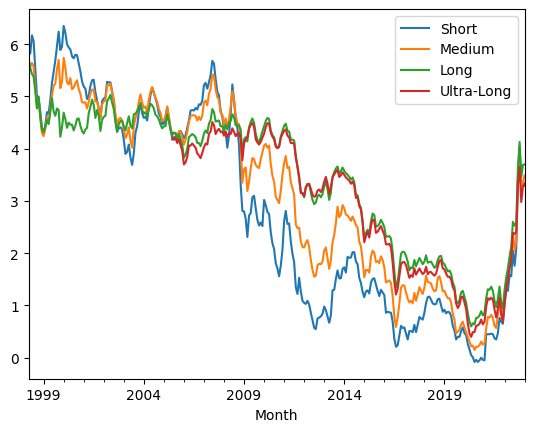

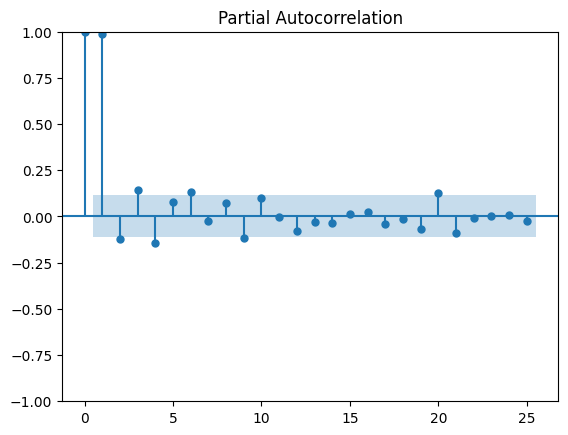

In [25]:
gilt_df = pd.read_csv('../../Data/Historical_Average_Daily_Conventional_Gilt_Yields.csv')
gilt_df = strip_spaces(gilt_df)

gilt_df['Month'] = pd.to_datetime(gilt_df['Month'], format="%b-%Y")
gilt_df['Long'] = gilt_df['Long'].str.rstrip('%').astype('float')
gilt_df['Short'] = gilt_df['Short'].str.rstrip('%').astype('float')
gilt_df['Medium'] = gilt_df['Medium'].str.rstrip('%').astype('float')
gilt_df['Ultra-Long'] = gilt_df['Ultra-Long'].str.rstrip('%').astype('float')

gilt_df.plot.line(x="Month")
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
df_stationarityTest = adfuller(gilt_df['Long'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(gilt_df['Long'], lags=25)

#
# Create training and test data
#
train_data = gilt_df['Long'][:len(df)-100]
test_data = gilt_df['Long'][len(df)-100:]
#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(train_data, lags=1).fit()
#
# Print Summary
#
print(ar_model.summary(0.05))